In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import os
data_folder = '/Users/aidantang/Desktop/Gesture_recog/Feature_extract_dataV2'

import scipy.stats as stats
import statsmodels.api as sm

# Function to compute Pearson correlation and Linear Regression significance
def analyze_relationship(x, y, variable_name):
    # Pearson correlation
    r, p_value_corr = stats.pearsonr(x, y)
    
    # Linear Regression Analysis
    X = sm.add_constant(x)  # Add constant for intercept
    model = sm.OLS(y, X).fit()
    p_value_reg = model.pvalues[1]  # p-value for the predictor variable
    
    print(f"\nAnalysis for {variable_name}:")
    print(f"Pearson Correlation: r = {r:.4f}, p-value = {p_value_corr:.4f}")
    print(f"Linear Regression: Coefficient = {model.params[1]:.4f}, p-value = {p_value_reg:.4f}")
    
    if p_value_corr < 0.05:
        print(f"→ The correlation between {variable_name} and Accuracy is statistically significant (p < 0.05).")
    else:
        print(f"→ No significant correlation found (p >= 0.05).")
    
    if p_value_reg < 0.05:
        print(f"→ The regression model suggests a significant effect of {variable_name} on Accuracy (p < 0.05).")
    else:
        print(f"→ No significant effect found in regression (p >= 0.05).")

Processing KNN for patient 1
(9124, 245)
Test accuracy for patient 1: 0.4843


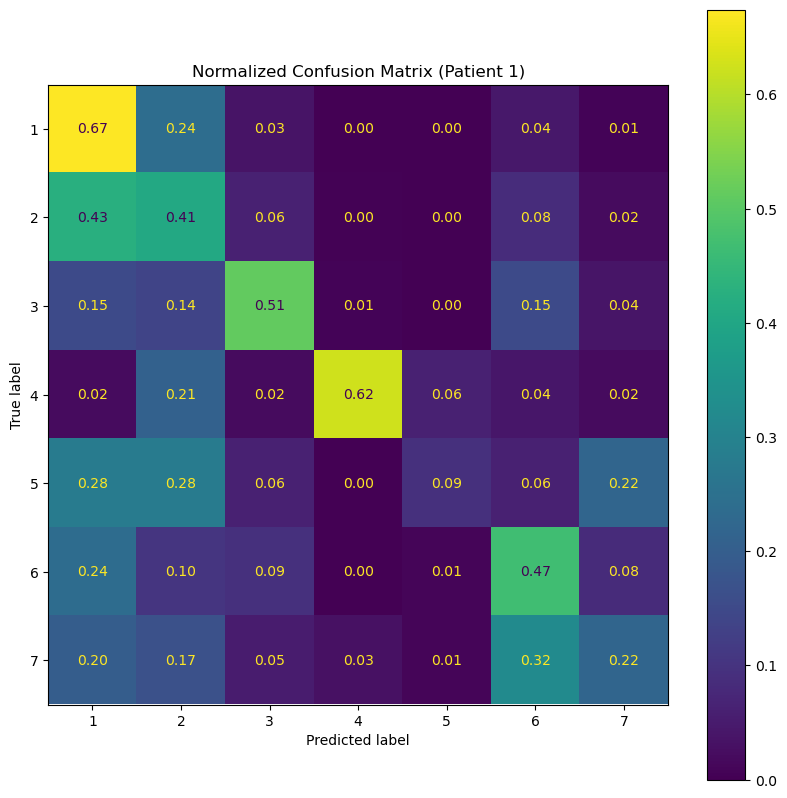

Processing KNN for patient 2
(8877, 245)
Test accuracy for patient 2: 0.6217


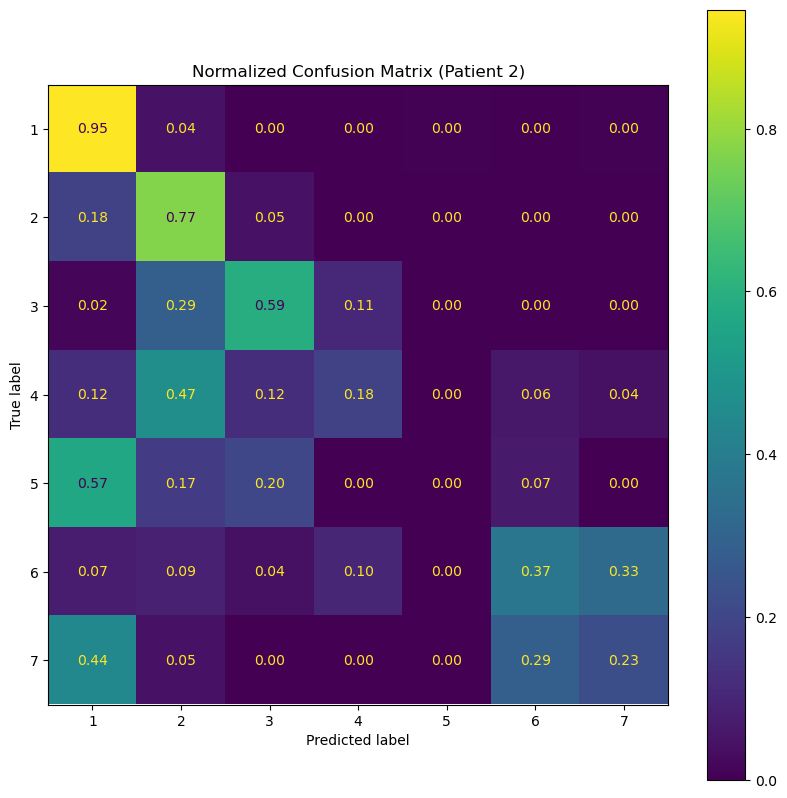

Processing KNN for patient 3
(9007, 245)
Test accuracy for patient 3: 0.4674


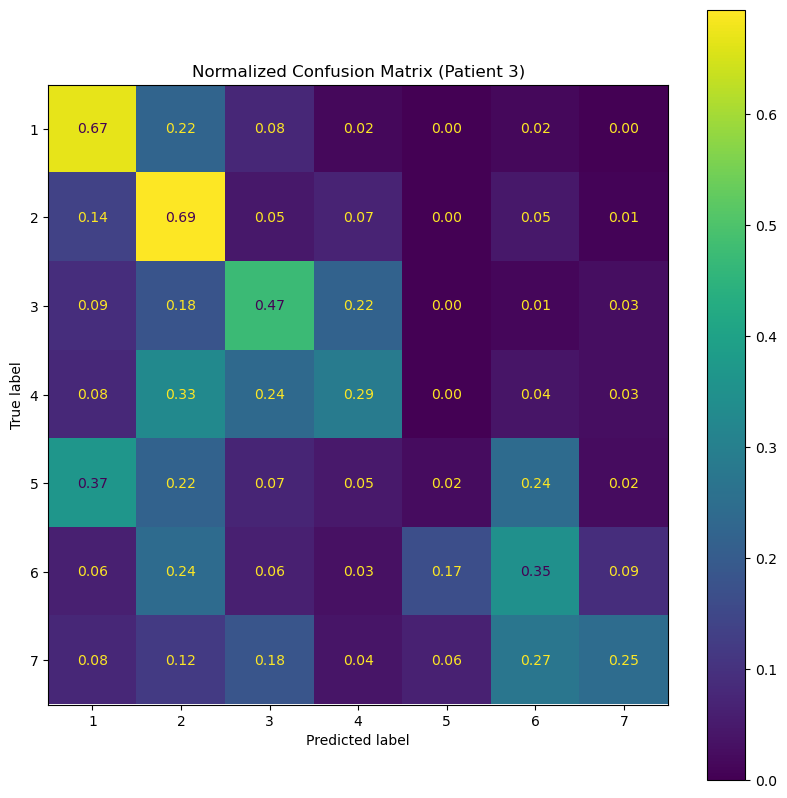

Processing KNN for patient 4
(9026, 245)
Test accuracy for patient 4: 0.4740


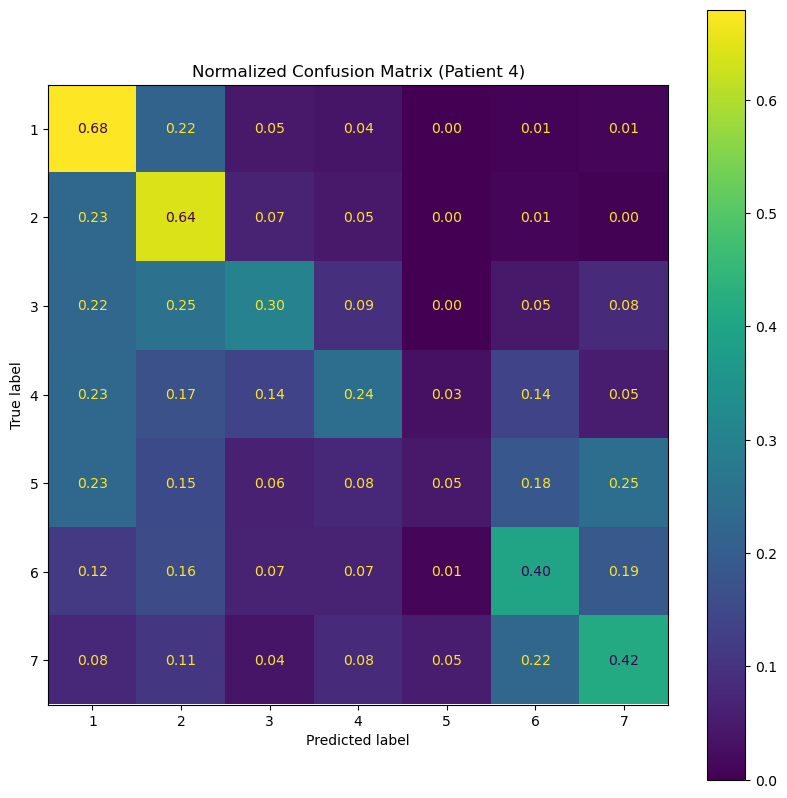

Processing KNN for patient 5
(9022, 245)
Test accuracy for patient 5: 0.4130


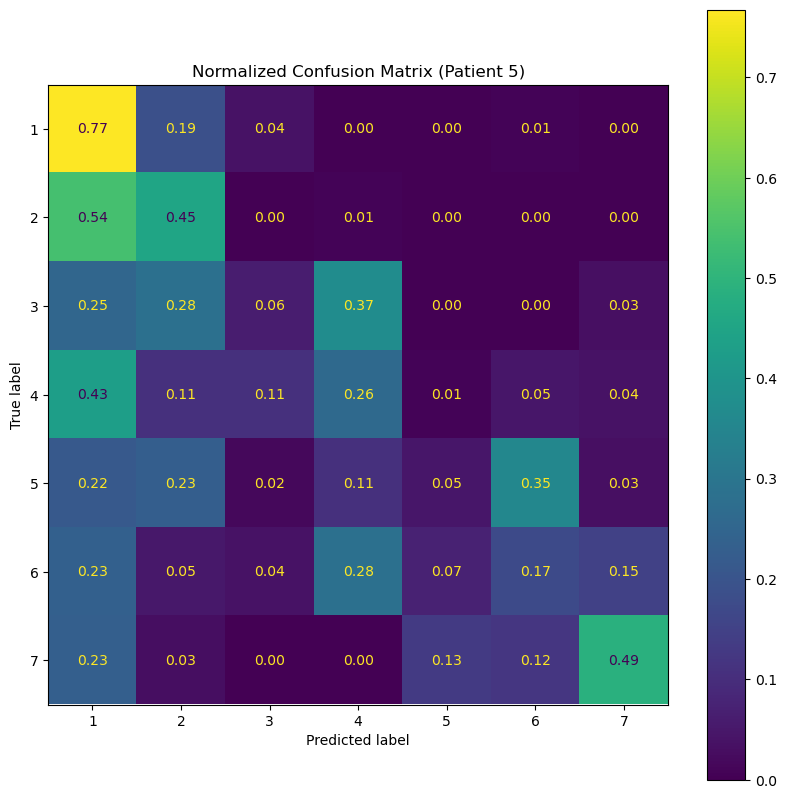

Processing KNN for patient 6
(9024, 245)
Test accuracy for patient 6: 0.5119


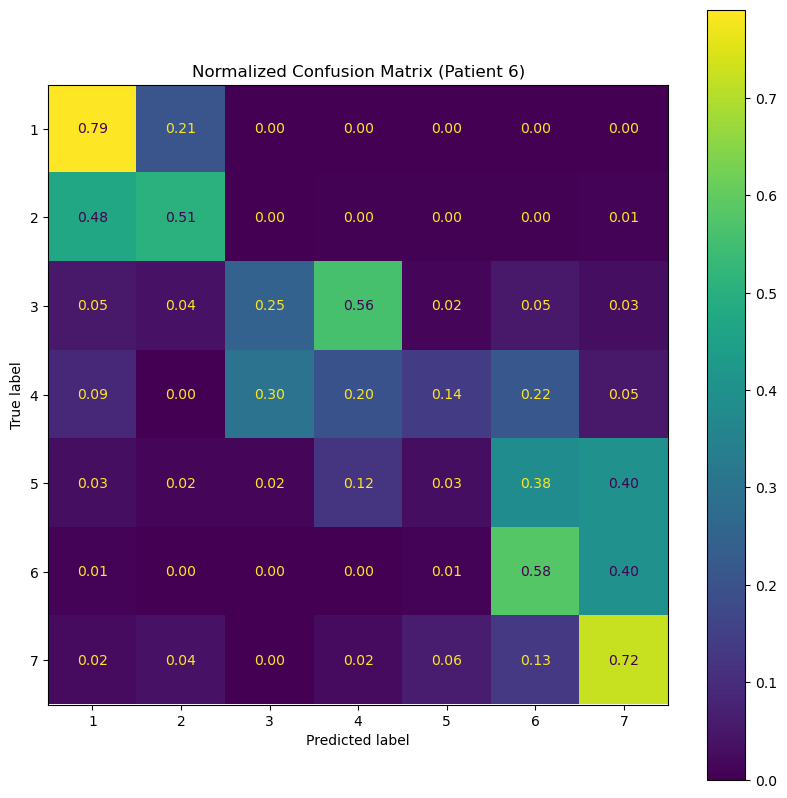

Processing KNN for patient 7
(8807, 245)
Test accuracy for patient 7: 0.2422


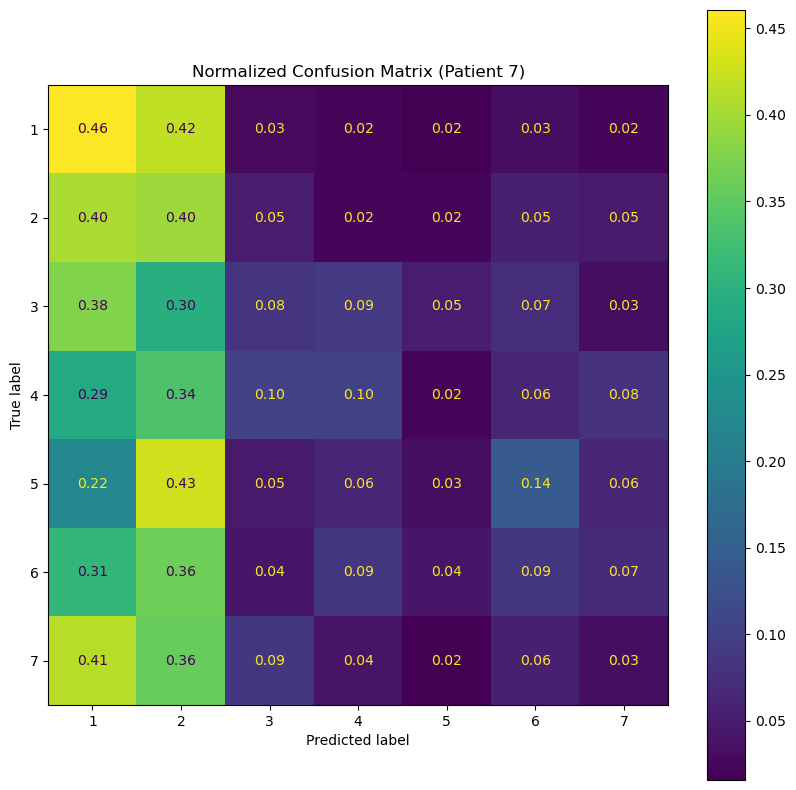

Processing KNN for patient 8
(8802, 245)
Test accuracy for patient 8: 0.5795


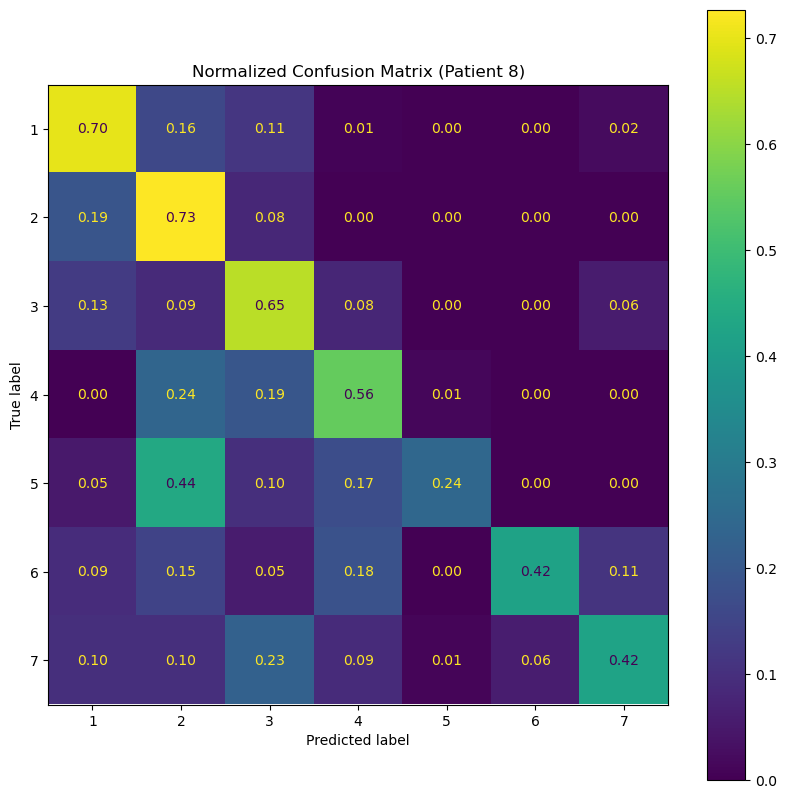

Processing KNN for patient 9
(8809, 245)
Test accuracy for patient 9: 0.5982


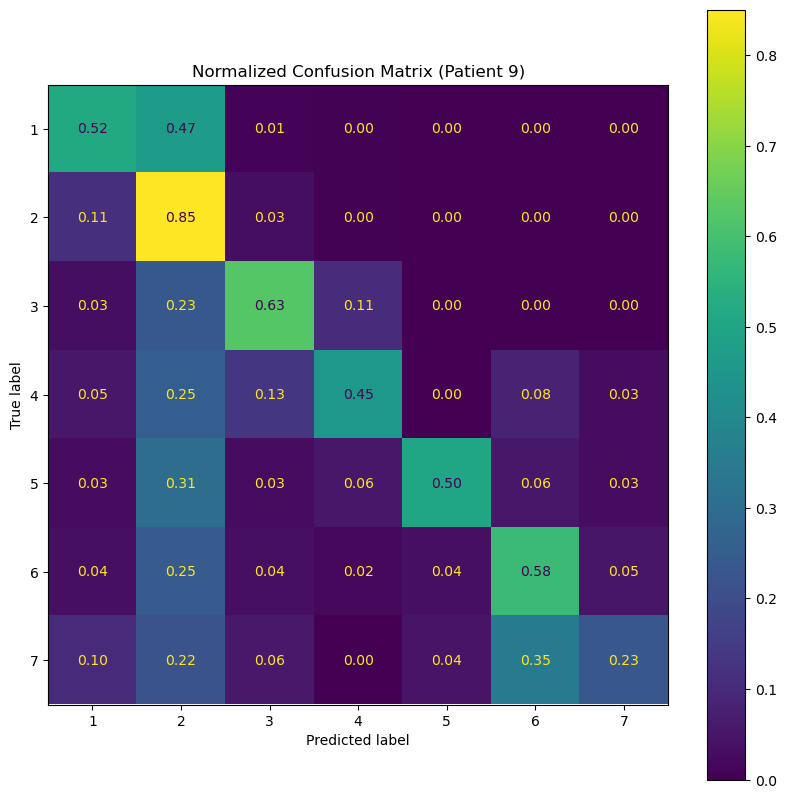

Processing KNN for patient 10
(8798, 245)
Test accuracy for patient 10: 0.5019


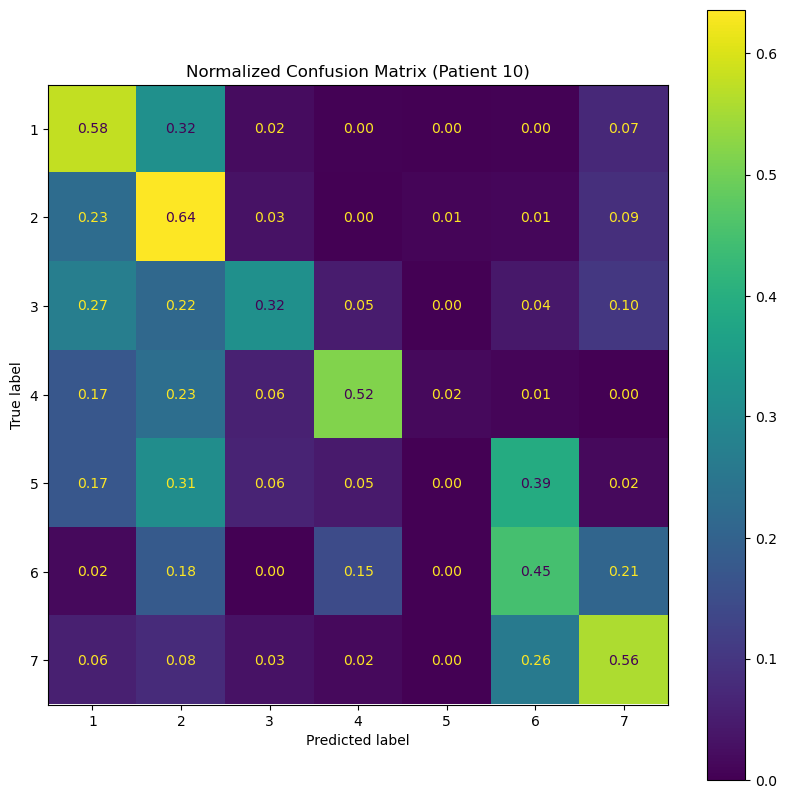

Processing KNN for patient 11
(8862, 245)
Test accuracy for patient 11: 0.5654


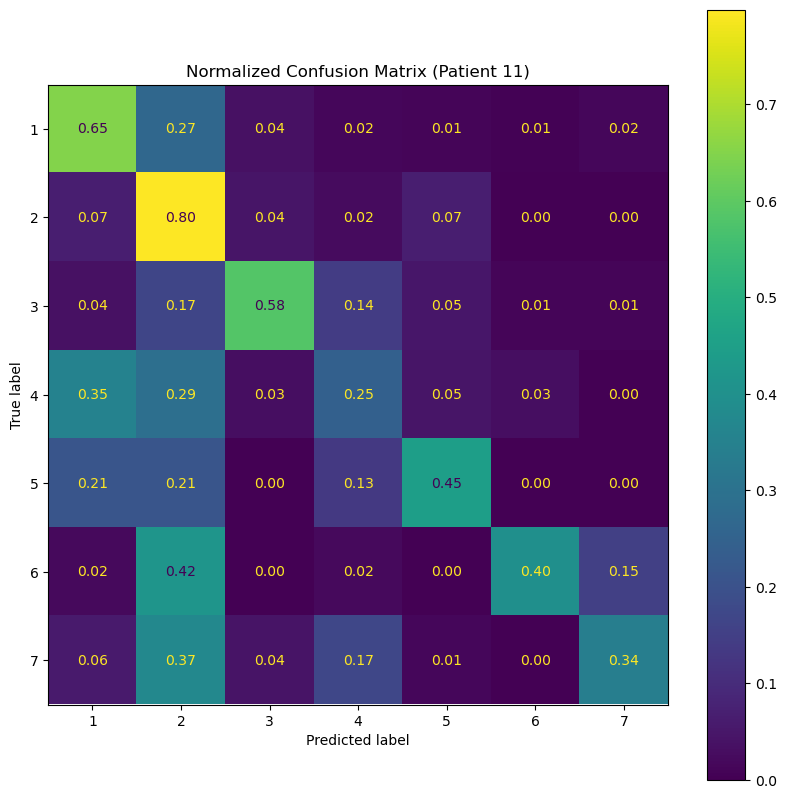

File not found for patient 12: /Users/aidantang/Desktop/Gesture_recog/Feature_extract_dataV2/S12_features_regrouped.csv


In [15]:

# Store results for plotting
results = []

# List of patient IDs
patient_ids = range(1, 13)

# Iterate over all patients
for patient_id in patient_ids:
    file_path = os.path.join(data_folder, f'S{patient_id}_features_regrouped.csv')
    if not os.path.exists(file_path):
        print(f"File not found for patient {patient_id}: {file_path}")
        continue
    print(f"Processing KNN for patient {patient_id}")
    
    # Load the data
    data = pd.read_csv(file_path)
    print(data.shape)
    # Drop windows with stimulus = 0 (rest state)
    data = data[data['Stimulus'] != 0]
    data = data.fillna(0)
    # Split data into train, validation, and test sets based on Repetition
    train_data = data[data['Repetition'].isin([1, 2, 3])]
    val_data = data[data['Repetition'].isin([4, 5])]
    test_data = data[data['Repetition'].isin([6])]
    
    # Separate features and labels
    feature_cols = [col for col in data.columns if col not in ['Stimulus', 'Repetition', 'Years_Since_Amputation', 'Forearm_Percentage','Myoelectric_Use']]
    X_train, y_train = train_data[feature_cols], train_data['Stimulus']
    X_val, y_val = val_data[feature_cols], val_data['Stimulus']
    X_test, y_test = test_data[feature_cols], test_data['Stimulus']
    
    # Standardize features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)
    
    # Find the best k value
    neighbor_range = range(1, 50)
    best_accuracy = 0
    best_n_neighbors = 0

    for n in neighbor_range:
        knn = KNeighborsClassifier(n_neighbors=n, p=1)
        knn.fit(X_train, y_train)
        y_val_pred = knn.predict(X_val)
        accuracy = accuracy_score(y_val, y_val_pred)
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_n_neighbors = n

    # Find the best distance metric (p)
    p_range = range(1, 4)
    best_p_value = 1  # Default to 1 if no improvement
    for p in p_range:
        knn = KNeighborsClassifier(n_neighbors=best_n_neighbors, p=p)
        knn.fit(X_train, y_train)
        y_val_pred = knn.predict(X_val)
        accuracy = accuracy_score(y_val, y_val_pred)
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_p_value = p

    # Final KNN model
    knn = KNeighborsClassifier(n_neighbors=best_n_neighbors, p=best_p_value)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred)
    print(f"Test accuracy for patient {patient_id}: {test_accuracy:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred, normalize='true')
    unique_labels = sorted(y_test.unique())
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_labels)
    fig, ax = plt.subplots(figsize=(10, 10))
    disp.plot(cmap='viridis', values_format=".2f", ax=ax)
    plt.title(f'Normalized Confusion Matrix (Patient {patient_id})')
    plt.show()

    forearm_col_name = [col for col in data.columns if "Forearm_Percentage" in col][0]
    years_col_name = [col for col in data.columns if "Years_Since_Amputation" in col][0]
    myo_col_name = [col for col in data.columns if "Myoelectric_Use" in col][0]

    ForearmPercentage = data[forearm_col_name].unique()[0]
    YearsSinceAmputation = data[years_col_name].unique()[0]
    MyoelectricUse = data[myo_col_name].unique()[0]
    
    # Store results
    results.append({
        'PatientID': patient_id,
        'TestAccuracy': test_accuracy,
        'ForearmPercentage': ForearmPercentage,
        'YearsSinceAmputation': YearsSinceAmputation,
        'MyoelectricUse': MyoelectricUse,
    })



# Convert results to a DataFrame
results_df = pd.DataFrame(results)




In [16]:

print(results_df)

    PatientID  TestAccuracy  ForearmPercentage  YearsSinceAmputation  \
0           1      0.484324                0.5                    13   
1           2      0.621705                0.7                     6   
2           3      0.467446                0.3                     5   
3           4      0.473973                0.4                     1   
4           5      0.413022                0.9                     1   
5           6      0.511861                0.4                    13   
6           7      0.242224                0.0                     7   
7           8      0.579528                0.5                     5   
8           9      0.598179                0.9                    14   
9          10      0.501919                0.5                     2   
10         11      0.565421                0.9                     5   

    MyoelectricUse  
0               13  
1                0  
2                8  
3                0  
4                0  
5        

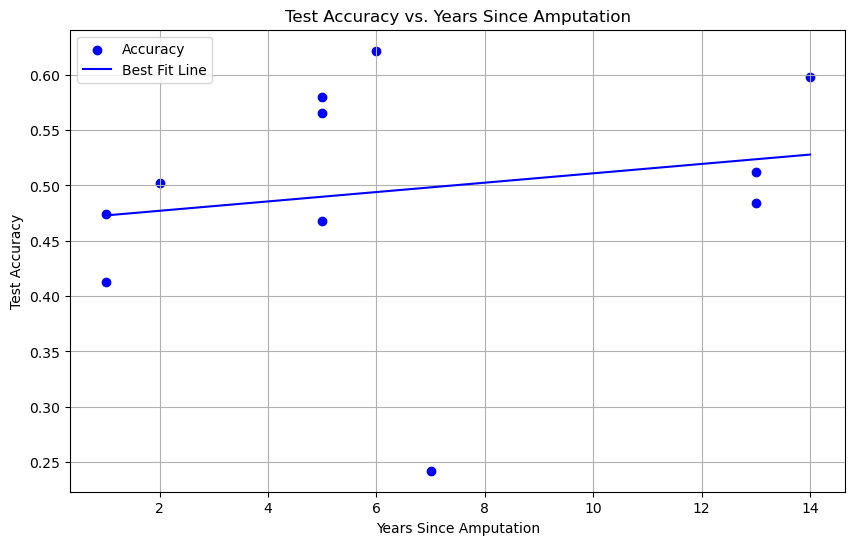

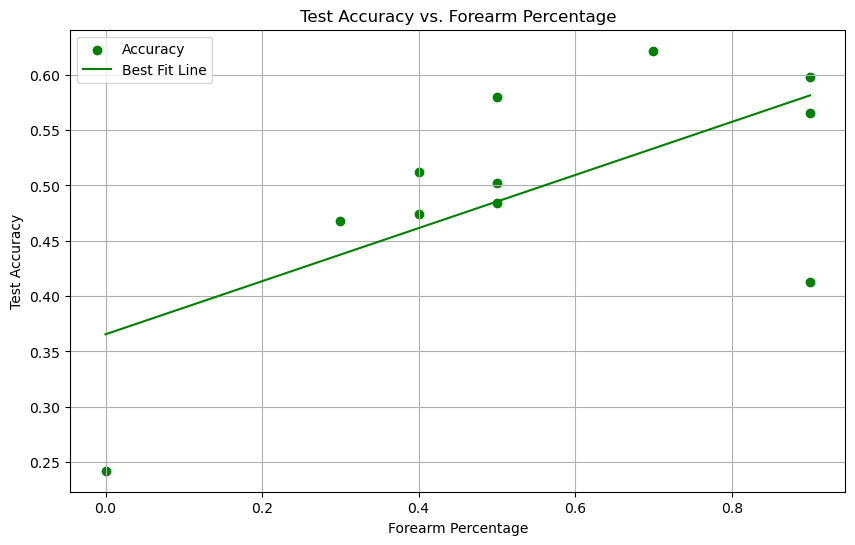

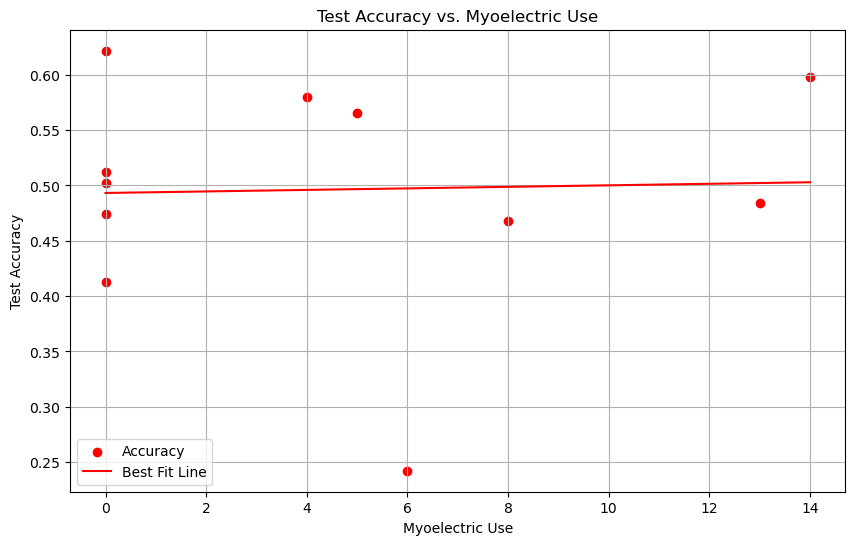

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Plot Accuracy vs Years Since Amputation
plt.figure(figsize=(10, 6))
plt.scatter(results_df['YearsSinceAmputation'], results_df['TestAccuracy'], c='blue', label='Accuracy')

# Line of best fit
coeffs = np.polyfit(results_df['YearsSinceAmputation'], results_df['TestAccuracy'], deg=1)
line = np.poly1d(coeffs)
x_vals = np.linspace(results_df['YearsSinceAmputation'].min(), results_df['YearsSinceAmputation'].max(), 100)
plt.plot(x_vals, line(x_vals), color='blue', label='Best Fit Line')

plt.xlabel('Years Since Amputation')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy vs. Years Since Amputation')
plt.grid(True)
plt.legend()
plt.show()

# Plot Accuracy vs Forearm Percentage
plt.figure(figsize=(10, 6))
plt.scatter(results_df['ForearmPercentage'], results_df['TestAccuracy'], c='green', label='Accuracy')

# Line of best fit
coeffs = np.polyfit(results_df['ForearmPercentage'], results_df['TestAccuracy'], deg=1)
line = np.poly1d(coeffs)
x_vals = np.linspace(results_df['ForearmPercentage'].min(), results_df['ForearmPercentage'].max(), 100)
plt.plot(x_vals, line(x_vals), color='green', label='Best Fit Line')

plt.xlabel('Forearm Percentage')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy vs. Forearm Percentage')
plt.grid(True)
plt.legend()
plt.show()

# Plot Accuracy vs Myoelectric Use
plt.figure(figsize=(10, 6))
plt.scatter(results_df['MyoelectricUse'], results_df['TestAccuracy'], c='red', label='Accuracy')

# Line of best fit
coeffs = np.polyfit(results_df['MyoelectricUse'], results_df['TestAccuracy'], deg=1)
line = np.poly1d(coeffs)
x_vals = np.linspace(results_df['MyoelectricUse'].min(), results_df['MyoelectricUse'].max(), 100)
plt.plot(x_vals, line(x_vals), color='red', label='Best Fit Line')

plt.xlabel('Myoelectric Use')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy vs. Myoelectric Use')
plt.grid(True)
plt.legend()
plt.show()


In [18]:

# Apply analysis to each variable
analyze_relationship(results_df['YearsSinceAmputation'], results_df['TestAccuracy'], "Years Since Amputation")
analyze_relationship(results_df['ForearmPercentage'], results_df['TestAccuracy'], "Forearm Percentage")
analyze_relationship(results_df['MyoelectricUse'], results_df['TestAccuracy'], "Myoelectric Use")



Analysis for Years Since Amputation:
Pearson Correlation: r = 0.1921, p-value = 0.5716
Linear Regression: Coefficient = 0.0042, p-value = 0.5716
→ No significant correlation found (p >= 0.05).
→ No significant effect found in regression (p >= 0.05).

Analysis for Forearm Percentage:
Pearson Correlation: r = 0.6467, p-value = 0.0315
Linear Regression: Coefficient = 0.2399, p-value = 0.0315
→ The correlation between Forearm Percentage and Accuracy is statistically significant (p < 0.05).
→ The regression model suggests a significant effect of Forearm Percentage on Accuracy (p < 0.05).

Analysis for Myoelectric Use:
Pearson Correlation: r = 0.0346, p-value = 0.9196
Linear Regression: Coefficient = 0.0007, p-value = 0.9196
→ No significant correlation found (p >= 0.05).
→ No significant effect found in regression (p >= 0.05).


/var/folders/2v/6zvn9f795zd164wfvwjybwqr0000gn/T/ipykernel_88463/1933283651.py:22: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/var/folders/2v/6zvn9f795zd164wfvwjybwqr0000gn/T/ipykernel_88463/1933283651.py:26: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/var/folders/2v/6zvn9f795zd164wfvwjybwqr0000gn/T/ipykernel_88463/1933283651.py:22: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/var/folders/2v/6zvn9f795zd164wfvwjybwqr0000gn/T/

In [19]:
import plotly.graph_objects as go
import numpy as np
from scipy.interpolate import griddata

#data
x = results_df['ForearmPercentage']
y = results_df['YearsSinceAmputation']
z = results_df['TestAccuracy']

#Create a grid for Years Since Amputation and Forearm Percentage
xi = np.linspace(x.min(), x.max(), 100)
yi = np.linspace(y.min(), y.max(), 100)
xi, yi = np.meshgrid(xi, yi)

#Interpolate z values to create a grid
zi = griddata((x, y), z, (xi, yi), method='linear')

#3D surface plot with contour lines
fig = go.Figure(data=[go.Surface(
    x=xi,
    y=yi,
    z=zi,
    colorscale='Viridis',  # Use a colormap for gradient
    contours=dict(
        z=dict(
            show=True,  # Show contour lines
            usecolormap=True,  # Use the colormap for the contours
            project_z=True  # Project contours onto the z-plane
        )
    )
)])

#Labels
fig.update_layout(
    title='Interactive 3D Contour Plot: Test Accuracy vs. Years Since Amputation and Forearm Percentage',
    scene=dict(
        xaxis_title='Forearm Percentage',
        yaxis_title='Years Since Amputation',
        zaxis_title='Test Accuracy',
    ),
    width=800,
    height=700
)


fig.show()


In [20]:
import plotly.graph_objects as go
import numpy as np
from scipy.interpolate import griddata

#data
x = results_df['ForearmPercentage']
y = results_df['MyoelectricUse']
z = results_df['TestAccuracy']

#Create a grid for Years Since Amputation and Forearm Percentage
xi = np.linspace(x.min(), x.max(), 100)
yi = np.linspace(y.min(), y.max(), 100)
xi, yi = np.meshgrid(xi, yi)

#Interpolate z values to create a grid
zi = griddata((x, y), z, (xi, yi), method='linear')

#3D surface plot with contour lines
fig = go.Figure(data=[go.Surface(
    x=xi,
    y=yi,
    z=zi,
    colorscale='Viridis',  # Use a colormap for gradient
    contours=dict(
        z=dict(
            show=True,  # Show contour lines
            usecolormap=True,  # Use the colormap for the contours
            project_z=True  # Project contours onto the z-plane
        )
    )
)])

#Labels
fig.update_layout(
    title='Interactive 3D Contour Plot: Test Accuracy vs. Myoelectric Use and Forearm Percentage',
    scene=dict(
        xaxis_title='Forearm Percentage',
        yaxis_title='Myoelectric Use',
        zaxis_title='Test Accuracy',
    ),
    width=800,
    height=700
)


fig.show()
